# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


# Python Versions
Load the basic libraries and check their versions.

In [2]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")

Tensor Flow Version: 2.3.0
Keras Version: 2.4.0

Python 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
Pandas 1.1.2
Scikit-Learn 0.22.2.post1


# Configurations of GPU

Check GPU availability.

In [3]:
print("GPU is", "available" if tf.test.is_gpu_available() \
      else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


## Enabling and Testing GPU

First, you'll need to enable GPUs for the notebook.

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow.

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Upload your Google Drive to Google Colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Multiclass Classification

**Classification** is the process of predicting the class of given data points (supervised learning). 
The concept is that given a paper (abstract + title) we will try to infer the research theme of it. 

We will proceed with **Multiclass Classification**, as we now examine more than three potential classes/themes.

# Loading the Multi-Class Data Frame

* First, in jupyter notebook, we run the parser to our raw data and extract two modified csv files - one for binary classification purposes and one for multi-class classification .
* Then, we upload the files in Google Drive.
* In the code below, we select the path in *read* function to get the mlb_clf.csv file

In [6]:
# Import data
import pandas as pd
df2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/mlb_clf.csv")

# First, set the parameters of the notebook
pd.set_option('display.max_columns', 10) # display up to 10 columns
pd.set_option('display.max_rows', 10) # display up to 10 rows

display(df2)

,label,text
0,Study,Multivariate Granger causality between CO2 emi...
1,Study,Electricity consumption-GDP nexus in Pakistan:...
2,Study,Ecological total-factor energy efficiency of r...
3,Method,Exploration and corrective measures of greenho...
4,Study,Solutions for improving the energy efficiency ...
...,...,...
820,Study,How to quantify the resolution of surface clim...
821,Study,A visual method to identify significant latitu...
822,Study,Effect of production system and farming strate...
823,Study,The effect of future climate scenarios on the ...


In [7]:
# Getting some information about our data (EDA was performed to the 'parser_eda_extract.ipynb')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   825 non-null    object
 1   text    825 non-null    object
dtypes: object(2)
memory usage: 13.0+ KB


We have 825 papers of text to work with.

In [8]:
# Getting the input and output data
texts = df2['text']
themes = df2['label']

In [9]:
# Counting the frequency of each label
from collections import Counter

theme_counts = Counter(themes)
theme_counts.most_common()

[('Study', 628),
 ('Method', 74),
 ('Review', 29),
 ('Interview', 25),
 ('Policy', 19),
 ('Tool', 11),
 ('Prototype', 9),
 ('Treatment', 9),
 ('Evaluation', 6),
 ('Diagnostic Tool', 4),
 ('Other', 3),
 ('Clinical Trial', 3),
 ('Diagnositc Tool', 2),
 ('Search', 1),
 ('Device', 1),
 ('Infrastructure', 1)]

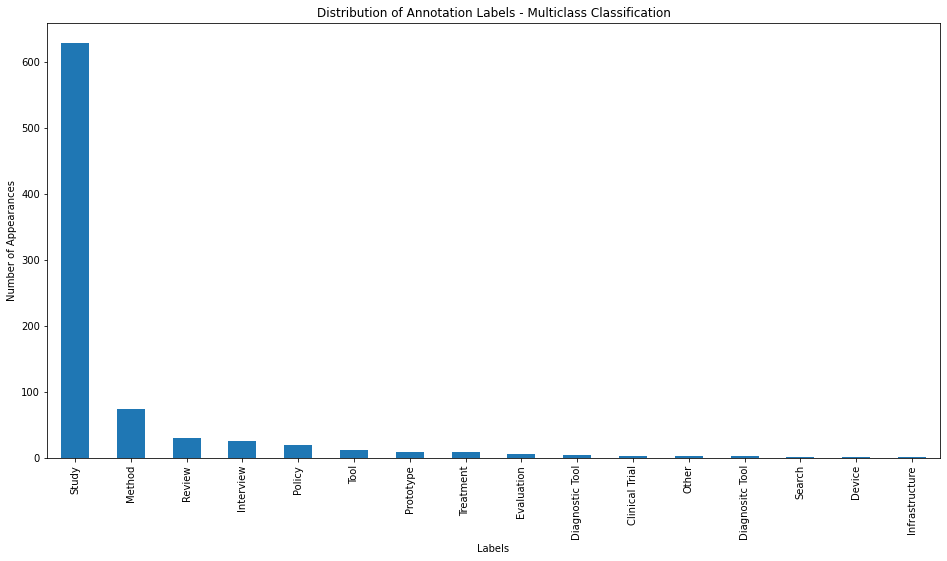

In [10]:
# Visualize the labels' frequency by creating a histogram plot
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (16, 8))
plt.title("Distribution of Annotation Labels - Multiclass Classification")
plt.xlabel('Labels')
plt.ylabel('Number of Appearances')

df2['label'].value_counts().plot(kind='bar')

Obviously our dataset is highly unbalanced.
In this case, random sampling is a very bad option for splitting. 

We reach the conclusion that we have to use stratified sampling in order to split the class proportionally between training and test set.

The next step is to select the most common labels for the classification. By evaluating the results, we decide to include the top-9 labels which have at least 9 counts. 

We took into consideration that, during the annotation process, it was obligatory that each paper could have only one research theme.

In [11]:
# Extract the top 9 labels
top_labels = theme_counts.most_common()[:9]
top_labels # list of tuples

convert_to_list = [item for t in top_labels for item in t]

# Convert to list of strings
top_labels = [lbl for lbl in convert_to_list if isinstance(lbl, str)]
print(top_labels)

['Study', 'Method', 'Review', 'Interview', 'Policy', 'Tool', 'Prototype', 'Treatment', 'Evaluation']


In [12]:
# Keep only the texts that are in the given List of top labels
df_top_labels = df2[df2['label'].isin(top_labels)].reset_index(drop=True)
display(df_top_labels.sample(10))

,label,text
484,Study,[Mortality from suicide in indigenous children...
9,Study,A roadmap for China to peak carbon dioxide emi...
743,Study,Under five mortality patterns and associated m...
690,Study,"Title: Changes in forest production, biomass a..."
513,Study,"Traumatic brain injury in the Netherlands, tre..."
392,Study,Title: Do we recover from vacation? Meta-analy...
524,Study,Are older drivers actually at higher risk of i...
256,Study,﻿Assessment of reproductive health and violenc...
375,Study,Title: Hierarchical measurement structure in t...
357,Study,Qualifying information on deaths and serious i...


In [13]:
# we check again the size of our dataset
df_top_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   810 non-null    object
 1   text    810 non-null    object
dtypes: object(2)
memory usage: 12.8+ KB


We observe that now our dataset consists of 810 papers of text.

In [14]:
# Getting the new input and output data for our analysis
texts_mlb = df_top_labels['text']
themes_mlb = df_top_labels['label']

We have to convert the categorical text output data into model-understandable numerical data.

**Label Encoder** is part of the SciKit Learn library and it is used to convert categorical data, or text data, into numbers, which our predictive models can better understand.

In [15]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labels = labelencoder.fit_transform(themes_mlb)

In [16]:
# Overview of input data
display(texts_mlb)

0      Multivariate Granger causality between CO2 emi...
1      Electricity consumption-GDP nexus in Pakistan:...
2      Ecological total-factor energy efficiency of r...
3      Exploration and corrective measures of greenho...
4      Solutions for improving the energy efficiency ...
                             ...                        
805    How to quantify the resolution of surface clim...
806    A visual method to identify significant latitu...
807    Effect of production system and farming strate...
808    The effect of future climate scenarios on the ...
809    Comparing environmental impacts of beef produc...
Name: text, Length: 810, dtype: object

In [17]:
# Overview of output data
display(labels[:20])

array([6, 6, 6, 2, 6, 6, 6, 3, 6, 6, 2, 6, 6, 6, 3, 2, 2, 2, 6, 6])

In [18]:
# Sanity check between texts and labels
print(len(texts_mlb) == len(labels))

True


# Preprocessing the dataset

The papers that comprise our dataset, originate from an annotation tool - [link here](https://inventory.clarin.gr/) . 

This means that most of heavy preprocessing such as
- special characters,
- tags, html\code\xml etc. ,

was conducted by the annotation tool during upload. 
Even so we continue with the following preprocess methods, so as to better modify our dataset for the text classification that takes place later on this notebook.

In [19]:
import re

class annotation_preprocess:

    @staticmethod
    def remove_underscores(sentence):
        return re.sub(r'_[A-Za-z0-9]+', ' ', sentence)
    
    @staticmethod
    def remove_multiple_spaces(sentence):
        return re.sub(r' +', ' ', sentence)

    @staticmethod
    def remove_trailing_spaces(sentence):
        return sentence.strip()
    
def annotation_preprocess_row(row):
    row = annotation_preprocess.remove_underscores(row)
    row = annotation_preprocess.remove_multiple_spaces(row)
    row = annotation_preprocess.remove_trailing_spaces(row)
    row = row.lower()
    return row

Static methods, much like class methods, are methods that are bound to a class rather than its object.

They do not require a class instance creation. So, they are not dependent on the state of the object.

The difference between a static method and a class method is:

* Static method knows nothing about the class and just deals with the parameters.
* Class method works with the class since its parameter is always the class itself.

In [20]:
# Apply to the input data and display the results
texts_mlb = texts_mlb.apply(lambda row: annotation_preprocess_row(row))
display(texts_mlb)

0      multivariate granger causality between co2 emi...
1      electricity consumption-gdp nexus in pakistan:...
2      ecological total-factor energy efficiency of r...
3      exploration and corrective measures of greenho...
4      solutions for improving the energy efficiency ...
                             ...                        
805    how to quantify the resolution of surface clim...
806    a visual method to identify significant latitu...
807    effect of production system and farming strate...
808    the effect of future climate scenarios on the ...
809    comparing environmental impacts of beef produc...
Name: text, Length: 810, dtype: object

# Word Embeddings

You cannot feed raw text directly into deep learning models. Text data must be encoded as numbers to be used as input or output for machine learning and deep learning models. Words are called tokens and the process of splitting text into tokens is called **Tokenization**.

A **Word Embedding** is a class of approaches for representing words and documents using a dense vector representation.

It is an improvement over more the traditional bag-of-word model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. These representations were sparse because the vocabularies were vast and a given word or document would be represented by a large vector comprised mostly of zero values.

Instead, in an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. The position of a word in the learned vector space is referred to as its embedding.

For this deep learning project we will use 2 methods of learning word embeddings:
- GloVe
- Self-learned as part of a deep learning model

# Tokenizing input text data using Self-trained Word Embeddings

We set some hyperparameters for performing tokenization and preparing the standardized data representation, with explanations below (comments).

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# maximum number of words from our resulting tokenized data vocabulary,
# which are to be used, truncated after the 5000 most common words in our case. 
max_words = 5000

# Creates a tokenizer, configured to only take into account the 5000 most common words
tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
tokenizer

Regarding **oov_token**:
This is the token which will be used for tokens encountered during the tokenizing and encoding of test data sequences

Keras lets us define an **Out Of Vocab** token **(OOV)** - this will replace any unknown words with a token of our choosing. This is better than just throwing away unknown words since it tells our model there was information here.

In [22]:
samples = texts_mlb.tolist()

# Build the word index
# Generate tokens by counting frequency
tokenizer.fit_on_texts(samples)

In [23]:
# Turns strings into lists of integer indices, specifically, sequence of numbers
sequences = tokenizer.texts_to_sequences(samples)

# Get max/min text sequence length
seqmax = max([len(x) for x in sequences])
seqmin = min([len(x) for x in sequences])

print("Maximum sequence length is:", seqmax)
print()
print("Minimum sequence length is:", seqmin)

Maximum sequence length is: 811

Minimum sequence length is: 105


Quick explanation on some tokenizer functions:

- **word index:** dictionary that maps each word to a number (dictionary of words and their indices)
- **word_counts:** dictionary of words and the number of times they have appeared in text
- **word_docs:** dictionary of words and the number of documents the appeared in
- **document_count:** total number of documents



At the end you can see that words that are frequently used in discussions about *Sustainable Development Goals* have a lower token number.

In [24]:
print('Word Index')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(type(word_index))

print()
print('Word Counts')
print(tokenizer.word_counts)

print()
print('Word Docs')
print(tokenizer.word_docs)

print()
print('Document Count')
print(tokenizer.document_count)

print()
print('Some examples')
print('Token for the word "energy": {}'.format(word_index['energy']))
print('Token for the word "source": {}'.format(word_index['source']))
print('Token for the word "game": {}'.format(word_index['game']))
print()
print('We notice that the word "game" is rarely used in discussions concerning SDGs.')

Word Index
Found 13183 unique tokens.
<class 'dict'>

Word Counts
OrderedDict([('multivariate', 30), ('granger', 8), ('causality', 30), ('between', 631), ('co2', 84), ('emissions', 292), ('energy', 795), ('consumption', 201), ('fdi', 8), ('foreign', 29), ('direct', 68), ('investment', 52), ('and', 8837), ('gdp', 60), ('gross', 20), ('domestic', 135), ('product', 26), ('evidence', 204), ('from', 1202), ('a', 2982), ('panel', 38), ('of', 8463), ('bric', 2), ('brazil', 23), ('russian', 2), ('federation', 3), ('india', 75), ('china', 143), ('countries', 440), ('abstract', 396), ('this', 1148), ('paper', 183), ('addresses', 8), ('the', 10840), ('impact', 275), ('both', 264), ('economic', 241), ('growth', 130), ('financial', 51), ('development', 274), ('on', 1447), ('environmental', 316), ('degradation', 23), ('using', 400), ('cointegration', 13), ('technique', 26), ('for', 2327), ('period', 186), ('1980', 13), ('2007', 45), ('except', 21), ('russia', 3), ('1992–2007', 1), ('in', 5624), ('lo

We proceed with Keras **padding**, to make sure that all text sequences we feed into the model have the same length. 

When we are encoding our numeric sequence representations of the text data, our sentences lengths will not be uniform, and so we will need to select a maximum length for sentences and pad unused sentence positions in shorter sentences with a padding character. On the contrary, longer sequences are truncated so that they fit the desired length.

With **pad_sequences** by default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence. By default truncating is also set to **"pre"** , which truncates the beginning part of the sequence

Whether we pre-pad or post-pad sentences is our decision to make, and we have selected **"post"**, meaning that our sentence sequence numeric representations corresponding to word index entries will appear at the left-most positions of our resulting sentence vectors, while the padding characters ('0') will appear after our actual data at the right-most positions of our resulting sentence vectors.

In [25]:
# number of words, cut of text after 200 words
maxlen = 200 
pad_type = 'post'

# Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen)
data = pad_sequences(sequences, padding = pad_type, maxlen=maxlen)

print("Padded training sequences:\n", data)
print()
print('-' * 50)
print()
print("Padded training shape:", data.shape)

Padded training sequences:
 [[   1 4949  428 ... 1095    1   45]
 [ 195  144  550 ...    0    0    0]
 [1394   20 3069 ...   13    2 3070]
 ...
 [  88   33  315 ... 1593   36 2319]
 [  17   22  347 ...  220    4  446]
 [1356    3  601 ... 1702  606  484]]

--------------------------------------------------

Padded training shape: (810, 200)


# Splitting/Shuffling Dataset Procedure
Following code performs, data splitting in train-validation datasets,  knowning that we are dealing with an imbalanced dataset.

As mentioned before, we should split the raw dataset in Train - Test in a stratified manner in order to prevent the distribution of the training data to bias our model accordingly to it.

We choose to split the data according to Pareto principle (80/20 is the common occurring ratio).
- Training dataset
- Test/Validation dataset (unseen data)

In [26]:
# The raw input (abstracts)
x = data

# The raw output (multiclass research themes)
y = labels

In [27]:
# We will use this object to split the raw dataset in Train - Test in a stratified manner.
# This splits your class proportionally between training and test set.
from sklearn.model_selection import StratifiedShuffleSplit

test_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
test_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)

In [28]:
# splitting in train-val and test
x_train, x_val, y_train, y_val = None, None, None, None

# getting the indexes for each dataset
for train_index, val_index in test_sss.split(x, y):
    
    print("TRAIN:", train_index[:10], "VALID:", val_index[:10])
    
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

TRAIN: [590 751  53 488 363 644  79 527 786 355] VALID: [316 696 660 797 597 307 315  73 199 439]
TRAIN: [226 779 366 587 619 805 351 595  50 378] VALID: [ 25 557 562 636 131 246 670 480 476 356]
TRAIN: [243 140 495 307 218  37 182 385  58 548] VALID: [ 29  35 566 444   0 337 200 430 328 179]
TRAIN: [382 414 265 709 254 180 595 161 378 489] VALID: [231  85 676 117 293 463 383 428 391 236]
TRAIN: [484 788  16 453 731 539 522 327 636 630] VALID: [289 209 786 605 661 544 238 809 704 338]


In [29]:
# Datasets' size & shape after splitting
print("Initial Dataset size:", len(df_top_labels)) 
print("Training Dataset size:", len(x_train)) 
print("Test/Validation Dataset size:", len(x_val)) 
print()
print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()
print('x_val shape: {}'.format(x_val.shape))
print('y_val shape: {}'.format(y_val.shape))

Initial Dataset size: 810
Training Dataset size: 648
Test/Validation Dataset size: 162

x_train shape: (648, 200)
y_train shape: (648,)

x_val shape: (162, 200)
y_val shape: (162,)


# Pre-trained GloVe Embeddings

Since you are executing below UNIX commands during Colab session, the files will be available only for the running session. In case you want to re-run any steps, do not execute those commands again (better to comment them out).

In [30]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-10-18 20:10:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-18 20:10:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-18 20:10:34--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [31]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [32]:
from tqdm import tqdm

def load_glove_embeddings(dim: int = 100) -> dict:
    """
    Function that loads glove embeddings. 

    :param dim: The embeddings size (dimensions)
    :return:
    """
    print('Loading word vectors')

    embed_index = dict()  # We create a dictionary of word -> embedding

    fname = 'glove.6B.{}d.txt'.format(dim)

    f = open(fname)  # Open file

    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f, desc='Loading Embeddings', unit='word'):
        values = line.split()
        # The first value is the word, the rest are the values of the embedding
        word = values[0]
        # Load embedding
        embedding = np.asarray(values[1:], dtype='float32')

        # Add embedding to our embedding dictionary
        embed_index[word] = embedding
    f.close()

    print('Found %s word vectors.' % len(embed_index))

    return embed_index

In [33]:
pre_embedding_dim = 100  # We now use larger embeddings

embeddings_index = load_glove_embeddings(dim=pre_embedding_dim)

Loading Embeddings: 7819word [00:00, 39660.62word/s]

Loading word vectors


Loading Embeddings: 400000word [00:10, 37904.84word/s]

Found 400000 word vectors.


In [34]:
embeddings_index['energy']

array([ 0.014314 ,  0.68838  ,  1.0354   , -0.22272  ,  0.7122   ,
       -1.8591   , -0.54074  ,  0.3788   , -0.4473   ,  0.39239  ,
        0.015253 , -0.91126  , -0.75051  , -0.20166  , -0.38735  ,
       -0.76363  , -0.30962  ,  0.46411  ,  0.086319 , -0.48519  ,
       -0.23435  , -0.47433  , -0.0079533, -0.11603  , -0.51613  ,
        0.903    , -0.089598 ,  0.57729  , -0.22603  ,  0.72144  ,
       -0.25002  ,  0.1062   , -0.94918  , -0.084096 , -0.62692  ,
       -0.17111  ,  0.1704   ,  0.38448  ,  0.039208 , -0.12554  ,
        0.17141  , -1.1132   , -0.5683   , -0.093456 , -0.028492 ,
       -0.01072  , -0.58381  ,  0.46759  , -0.15049  , -0.59781  ,
        0.18358  , -0.11986  ,  0.14094  ,  1.0061   ,  0.35668  ,
       -2.1176   , -0.11615  ,  0.14937  ,  1.6014   ,  0.3073   ,
        0.68025  , -0.69607  , -0.69121  , -0.23822  ,  1.0161   ,
        0.46592  ,  0.5549   , -0.12957  ,  1.3661   , -0.39927  ,
        0.70148  , -0.023808 ,  0.42136  , -0.4654   ,  0.1101

In [35]:
embeddings_index['energy'].shape

(100,)

Not all words that are in our **annotation** vocabulary might be in the GloVe embedding though. For missing words it is wise to use random embeddings with the same mean and standard deviation as the GloVe embeddings.

In [36]:
def create_embeddings_matrix(emb_index: dict,
                             tokenizer: Tokenizer,
                             emb_dim: int = 100) -> np.ndarray:
    """

    :param emb_index: Embeddings Index
    :param tokenizer: Keras fitted tokenizer.
    :param emb_dim: Embeddings dimension.
    :return: A matrix of shape (nb_words, emb_dim) containing the globe embeddings.
    """
    assert emb_dim in [50, 100, 200, 300]

    # Create a matrix of all embeddings
    # (stacking=concatenating all the vectors)
    all_embs = np.stack(emb_index.values())  # .values() gets the all the arrays from the keys

    # Calculate mean
    emb_mean = all_embs.mean()
    # Calculate standard deviation
    emb_std = all_embs.std()

    print("Embeddings AVG: {} | STD: {}".format(emb_mean, emb_std))

    # We can now create an embedding matrix holding all word vectors.

    word_index = tokenizer.word_index

    # How many words are there actually. Because we may have requested X most common tokens
    # and the total tokens are X/2
    nb_words = min(max_words, len(word_index))

    # Create a random matrix with the same mean and std as the embeddings

    embedding_matrix = np.random.normal(emb_mean,  # mean
                                        emb_std,  # std
                                        (nb_words, emb_dim)) # shape of the matrix

    # The vectors need to be in the same position as their index.
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    
    counter = 0
    
    # Loop over all words in the word index
    for word, i in word_index.items():  # .items() return a tuple with (word, word_index)

        # If we are above the amount of words we want to use we do nothing
        if i >= max_words:
            continue

        # Get the embedding vector for the word
        embedding_vector = emb_index.get(word)

        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1
    
    print(f'Found {counter} pre-trained embeddings out of {nb_words}')
    
    return embedding_matrix

In [37]:
embedding_matrix = create_embeddings_matrix(
    emb_index=embeddings_index, 
    tokenizer=tokenizer, 
    emb_dim=pre_embedding_dim
    )

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Embeddings AVG: 0.004451991990208626 | STD: 0.4081574082374573
Found 4857 pre-trained embeddings out of 5000


This embedding matrix is used as weights for the embedding layer. This way, the embedding layer uses the pre-trained GloVe weights instead of random ones.

We can also set the embedding layer to NOT trainable. This means, Keras won't change the weights of the embeddings while training which makes sense since our embeddings are already trained.